# Project 1 - MTA

Start with the imports:

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Below we read a week's worth of turnstile dataset for MTA subway system in NYC.

In [2]:
data = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190330.txt")

In [3]:
data.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573


According to the MTA website, the features shown are defined as:

- C/A      = Control Area (A002)
- UNIT     = Remote Unit for a station (R051)
- SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
- STATION  = Represents the station name the device is located at
- LINENAME = Represents all train lines that can be boarded at this station. Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
- DATE     = Represents the date (MM-DD-YY)
- TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
- DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
    1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
    2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- ENTRIES  = The comulative entry register value for a device
- EXIST    = The cumulative exit register value for a device

The key motive of data exploration in this particular set is to look for some of the more popular stations. We can achieve that by looking at how many passengers use a specific turnstile, or a device located at one (ENTRIES accumulation). Looking at one specific device, we notice a weird trend:

In [4]:
data[(data["STATION"]=="116 ST") & (data["SCP"]=="01-00-01") & (data["C/A"]=='R257') & (data["UNIT"]=='R182')].tail(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
165231,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,05:00:00,REGULAR,92944,52347
165232,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,09:00:00,REGULAR,16796650,37627
165233,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,13:00:00,REGULAR,16796797,37719
165234,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,17:00:00,REGULAR,16797164,37852
165235,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,21:00:00,REGULAR,16797438,37970


At a certain point in time (around March 29th after 5am), the ENTRIES count jumps up significantly. Considering that there are 13 million people in NYC, it is impossible to have a 4 hour window where more than all of NYC population passes through a single turnstile in a subway station. We can attribute these to unforseen event such as device malfunction, device reset setting entries accumulation at random number, etc. There are also some devices where the opposite happens (sudden huge drop in consecutive audit events)

While many devices do not have this problem, and therefore total number of entries can be calculated, the devices with these problems must be identified. In order to do so, **we are iterating over the whole data, comparing diff between the two entries, and if it is greater than literature value (20 people will pass through a turnstile per min accoring to [this site](https://www.haywardturnstiles.com/learning-center/before-you-buy/how-many-turnstiles-do-i-need/)), then we flag the station device number.**

In order to accurately calculate the hour difference, we create a feature called "DATETIME" which will be a datetime object (pandas has one). We can also create another feature called "DAY" to show what day of the week it is.


In [5]:
data["DATETIME"]=data["DATE"]+' '+data["TIME"]
data["DATETIME"]=pd.to_datetime(data["DATETIME"])
data["DAY"]=data["DATETIME"].dt.day_name()
data.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,2019-03-23 00:00:00,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,2019-03-23 04:00:00,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,2019-03-23 08:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,2019-03-23 12:00:00,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,2019-03-23 16:00:00,Saturday


### 1.1. Separate out devices with large jumps in entry values

First step is to determine which devices have unusual jumps in the ENTRIES at some point during the week. We decided on using the 40/Min (to maybe account for busy location and also with a built-in buffer) and multiplied it by to calculate for a week window: 40\*60\*24\*7 ~ 400000. 

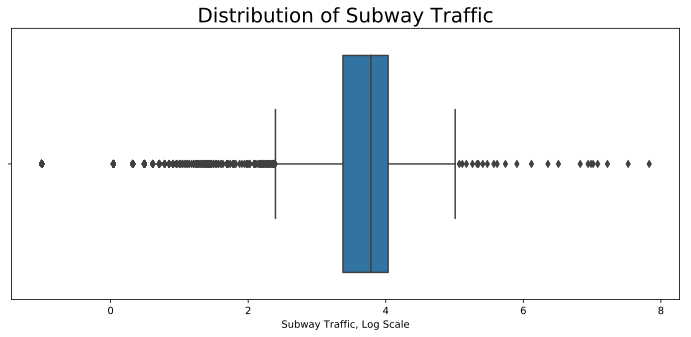

In [283]:
MAX_PEOPLE = 400000

data_entries=data.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
data_entries["diff"] = data_entries["max"]-data_entries["min"]

# Plot to see outlier
k = np.log10(data_entries["diff"]+0.1)
plt.figure(figsize=(12,5))
dist_plot=sns.boxplot(k);
# sns.despine(dist_plot)
dist_plot.set_title("Distribution of Subway Traffic", fontsize=20)
dist_plot.set_xlabel("Subway Traffic, Log Scale", fontsize=10)
fig_dist = dist_plot.get_figure();
fig_dist.savefig('Distribution_Traffic', format='png', dpi=1200);




In [ ]:
jumps = data_entries[data_entries["diff"] > MAX_PEOPLE].reset_index()
rest = data_entries[data_entries["diff"] <= MAX_PEOPLE]

In [7]:
print("From a total of %d devices" % (len(data_entries)))
print("We see %d devices that have large jumps" % len(jumps))
print("Remaining devices: %d" % len(rest))

From a total of 4849 devices
We see 14 devices that have large jumps
Remaining devices: 4835


With a list of devices we know has huge jumps, we can now filter out the original data to exclude all of them.

In [8]:
a=list(jumps["C/A"])
b=list(jumps["UNIT"])
c=list(jumps["SCP"])
d=list(jumps["STATION"])

data_not_jumps=data

for i in range(len(jumps)):
    jump_cond = np.array([a[i],b[i],c[i],d[i]])
    cols = ["C/A","UNIT","SCP","STATION"]
    
    data_not_jumps = data_not_jumps[~((data_not_jumps[cols]==jump_cond).all(1))]

In [9]:
print("Number of Original Datapoints: ", len(data))
print("Number of Datapoints after \"Jump\" data is taken out: ",len(data_not_jumps))

Number of Original Datapoints:  204595
Number of Datapoints after "Jump" data is taken out:  204016


### 1.2. Separate out devices with entry values declining over time

So now we have a partial data set where we removed all the devices from 1.1. We call this subset of the data "data_not_jumps". We can verify that we have removed those 14 devices by calling groupby and counting the list:

In [10]:
data_not_jumps.head(5)
data_not_jumps_entries=data_not_jumps.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
data_not_jumps_entries["diff"] = data_not_jumps_entries["max"]-data_not_jumps_entries["min"]
print("Remaining number of device is still",len(data_not_jumps_entries))



Remaining number of device is still 4835


Now we want to eliminate another set of devices where we notice something else unusual: consecutive audit events shows decrease in ENTRIES; We can capture these by using a for loop:

In [11]:
CA_INDEX = 0
UNIT_INDEX = 1
SCP_INDEX = 2
STATION_INDEX = 3
ENTRY_INDEX = 9
DATETIME_INDEX = 11
NEGATIVE_LIST=[]

for i in range(len(data_not_jumps.index)-1):
    
    entry_1 = data_not_jumps.iloc[i,ENTRY_INDEX]
    entry_2 = data_not_jumps.iloc[i+1,ENTRY_INDEX]
    time_1 = data_not_jumps.iloc[i,DATETIME_INDEX]
    time_2 = data_not_jumps.iloc[i+1,DATETIME_INDEX]
    CA1 = data_not_jumps.iloc[i,CA_INDEX]
    CA2 = data_not_jumps.iloc[i+1,CA_INDEX]
    UNIT1 = data_not_jumps.iloc[i,UNIT_INDEX]
    UNIT2 = data_not_jumps.iloc[i+1,UNIT_INDEX]
    SCP1 = data_not_jumps.iloc[i,SCP_INDEX]
    SCP2 = data_not_jumps.iloc[i+1,SCP_INDEX]
    
    
    if (CA1==CA2) & (SCP1==SCP2) & (UNIT1==UNIT2): # if the two entries are of the same device
        # If the 2nd entry-1st entry is negative
        if (entry_2-entry_1)<0:
            NEGATIVE_LIST.append([CA1,UNIT1,SCP1])

We have a list of the extracted device information (C/A, UNIT and SCP in a list); we can use it to filter out more devices.

In [12]:
neg_set = set(map(tuple,NEGATIVE_LIST))  # need to convert the inner lists to tuples so they are hashable
neg_list=list(neg_set)

neg_list=(pd.DataFrame(neg_list,columns=["C/A","UNIT","SCP"]))
len(neg_list)

71

In [13]:
a2=list(neg_list["C/A"])
b2=list(neg_list["UNIT"])
c2=list(neg_list["SCP"])

data_good = data_not_jumps

for i in range(len(neg_list)):
    neg_cond = np.array([a2[i],b2[i],c2[i]])
    cols = ["C/A","UNIT","SCP"]
    
    data_good = data_good[~((data_good[cols]==neg_cond).all(1))]

In [14]:
print("Number of Datapoints after \"Jump\" data is taken out:", len(data_not_jumps))
print("Number of Datapoints after \"negative diff\" data is taken out: ",len(data_good))

Number of Datapoints after "Jump" data is taken out: 204016
Number of Datapoints after "negative diff" data is taken out:  200990


In [164]:
data_good_entries=data_good.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
data_good_entries["diff"] = data_good_entries["max"]-data_good_entries["min"]

In [16]:
print("From a total of %d remaining devices" % (len(data_not_jumps_entries)))
print("We see %d devices that have negative diff" % len(neg_list))
print("Remaining devices: %d" % len(data_good_entries))

From a total of 4835 remaining devices
We see 71 devices that have negative diff
Remaining devices: 4764


### 1.3 Looking at Top 40 popular entries by Device

Now we have the data we consider "good" and can look at the Top 40 (~10%) of the devices by cumulative number of entries within the 7 day period. This is the supported data for our suggestions - we want to suggest placing members of WomenTechWomenYes (WTWY) at these locations in order to gather email sign-ups for people that will show up to their Gala free of charge.

In [17]:
top10 = data_good_entries.sort_values("diff",ascending=False).head(len(data_good_entries)//10)
top10

max         min    diff
STATION         C/A   UNIT SCP                                     
WALL ST         R204  R043 02-06-00      460465      330850  129615
59 ST COLUMBUS  N051  R084 02-00-00    13283135    13242629   40506
14 ST-UNION SQ  A033  R170 02-00-05    16100319    16060153   40166
W 4 ST-WASH SQ  N083  R138 01-06-01    21245719    21206937   38782
BEDFORD AV      H009  R235 00-03-04    10572852    10535763   37089
GRD CNTRL-42 ST R238  R046 00-03-04    37122001    37085154   36847
                R240  R047 00-03-08    38146777    38111855   34922
                R238  R046 00-03-03     5870309     5835563   34746
59 ST COLUMBUS  N051  R084 02-00-01     9420393     9385675   34718
34 ST-HERALD SQ N506  R022 00-05-05      616710      582776   33934
14 ST-UNION SQ  A034  R170 03-03-02    11864716    11830924   33792
                R221  R170 01-00-00    14491482    14457857   33625
59 ST COLUMBUS  N051  R084 02-00-02    24332764    24299437   33327
GRD CNTRL-42 ST R238  R046 00-03-02     3663148     3630290   32858
JAMAICA CENTER  N606  R025 00-00-08    41275429    41242655   32774
86 ST-2 AVE     N701  R571 00-00-00     3652121     3619381   32740
57 ST-7 AV      A011  R080 01-00-04     2870397     2837673   32724
TIMES SQ-42 ST  R151  R033 00-00-01  1718445952  1718413578   32374
8 AV            D002  R390 00-03-01     2499958     2467715   32243
14 ST-UNION SQ  R221  R170 01-00-02    15670498    15638500   31998
                A033  R170 02-00-04     5322544     5290612   31932
34 ST-HERALD SQ A022  R022 01-00-00    26710987    26679306   31681
59 ST COLUMBUS  N051  R084 02-03-03     1847755     1816094   31661
JAMAICA CENTER  N606  R025 00-00-07    27097657    27066387   31270
14 ST-UNION SQ  A037  R170 05-00-02     6706638     6675485   31153
57 ST-7 AV      A010  R080 00-00-07     1705231     1674104   31127
42 ST-PORT AUTH N063A R011 00-00-07    29462308    29431250   31058
14 ST-UNION SQ  A037  R170 05-00-03    25196519    25165551   30968
34 ST-PENN STA  R138  R293 00-00-00     9495898     9465056   30842
FLUSHING-MAIN   R533  R055 00-03-00    15465512    15434853   30659
...                                         ...         ...     ...
86 ST           R250  R179 00-00-08    29134455    29118721   15734
96 ST           R168A R168 00-03-02    11408549    11392820   15729
NEWKIRK AV      R643  R135 00-00-00    13868012    13852285   15727
CATHEDRAL PKWY  R172  R192 00-00-01      122606      106889   15717
28 ST           R133  R272 00-00-01     5558967     5543306   15661
42 ST-PORT AUTH N062A R010 00-06-00     5281173     5265513   15660
GRD CNTRL-42 ST R236  R045 00-03-01      144925      129288   15637
47-50 STS ROCK  N500  R020 00-03-03     5690892     5675291   15601
34 ST-PENN STA  N072  R012 05-03-00     3699296     3683696   15600
GRD CNTRL-42 ST R240  R047 00-00-00     5150492     5134907   15585
2 AV            N523  R300 00-00-01     6133712     6118153   15559
59 ST           R244  R050 00-06-01     4234781     4219259   15522
42 ST-PORT AUTH N062A R010 00-05-01    20396829    20381326   15503
PARKSIDE AV     B014  R148 00-00-02    14257023    14241520   15503
34 ST-PENN STA  N067  R012 00-03-01     4417225     4401723   15502
BLEECKER ST     R217A R194 00-00-02    12301627    12286145   15482
TIMES SQ-42 ST  R147  R033 04-00-04    16172083    16156614   15469
FLUSHING AV     J007  R377 00-00-02     5142313     5126848   15465
ELMHURST AV     N325A R218 00-00-02     2435822     2420357   15465
SPRING ST       R215  R322 00-00-00     4822798     4807361   15437
ATL AV-BARCLAY  R610  R057 00-03-07      180681      165256   15425
METROPOLITAN AV N409  R268 00-00-02    16798524    16783116   15408
HOUSTON ST      R121  R290 01-06-01    11121850    11106460   15390
161/YANKEE STAD N203  R195 00-00-03   556713815   556698427   15388
111 ST          R530  R310 00-00-01    15559032    15543659   15373
47-50 STS ROCK  N500  R020 00-03-04     8094448     8079099   15349
7 AV            N539  R288 00-00

In [18]:
top10 = top10.reset_index()

Instead of looking at the Top 10% by device, we can also count how many belong in each station and look at the Top 10 Stations by number of popular devices. The plot shows the following:

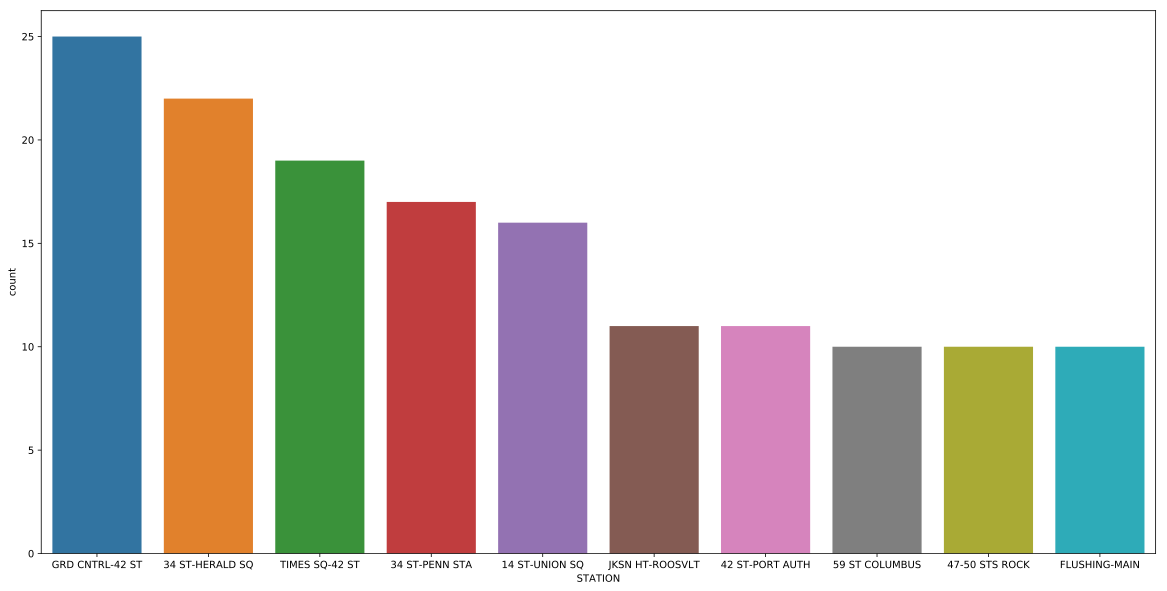

In [19]:
plt.figure(figsize=(20, 10))
ax=sns.countplot(x="STATION", data=top10, order=top10.STATION.value_counts().iloc[:10].index);
fig = ax.get_figure();
fig.savefig('Top 10 Stations, 1 Week', format='png', dpi=1200);

We are almost at our MVP - We believe we can make it more robust by looking at dataset over a longer period of time - 3 Months.

## 2. First MVP (Minimal Viable Product) - Iterating our dataset over 3 months of data

In order to run it again with 3 months of data, we read 12 turnstile data files and concatenate all resulting Pandas DataFrame into a single DataFrame object:

In [20]:
dates_list=['190112','190119','190126','190202','190209','190216','190223','190302','190309','190316','190323','190330']
full_data=pd.DataFrame()
for date in dates_list:
    full_data = pd.concat([full_data, pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_"+date+".txt")])


In [21]:
full_data.reset_index(inplace=True)
full_data.drop(['index'],axis=1,inplace=True)#'level_0','index'],axis=1,inplace=True)

Having concatenated the dataframes, we can sort by the device and then by time to get it in chronological order:

In [22]:
full_data_sorted=full_data.sort_values(['C/A','UNIT','SCP','DATE','TIME'])

Add DATETIME and DAY features to our 3 month dataset:

In [24]:
full_data_sorted["DATETIME"]=full_data_sorted["DATE"]+' '+full_data_sorted["TIME"]
full_data_sorted["DATETIME"]=pd.to_datetime(full_data_sorted["DATETIME"])
full_data_sorted["DAY"]=full_data_sorted["DATETIME"].dt.day_name()

In [241]:
full_data_sorted.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,03:00:00,REGULAR,6897012,2338472,2019-01-05 03:00:00,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,07:00:00,REGULAR,6897023,2338487,2019-01-05 07:00:00,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,11:00:00,REGULAR,6897083,2338565,2019-01-05 11:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,15:00:00,REGULAR,6897262,2338624,2019-01-05 15:00:00,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,19:00:00,REGULAR,6897572,2338679,2019-01-05 19:00:00,Saturday


Now we are ready to clean the data again as was in Section 1 and arrive to our results.

### 2.1. Separate out devices with large jumps in entry values

First filter out the devices with large jumps using groupby:

In [51]:
FULL_MAX_PEOPLE = MAX_PEOPLE * 12

full_data_entries=full_data_sorted.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
full_data_entries["diff"] = full_data_entries["max"]-full_data_entries["min"]
full_jumps = full_data_entries[full_data_entries["diff"] > FULL_MAX_PEOPLE].reset_index()
full_rest = full_data_entries[full_data_entries["diff"] <= FULL_MAX_PEOPLE]

In [27]:
print("From a total of %d devices" % (len(full_data_entries)))
print("We see %d devices that have large jumps" % len(full_jumps))
print("Remaining devices: %d" % len(full_rest))

From a total of 4905 devices
We see 109 devices that have large jumps
Remaining devices: 4796


Then we go back to our original dataset and filter out the original full data using the list of devices we want to remove:

In [28]:
a_full=list(full_jumps["C/A"])
b_full=list(full_jumps["UNIT"])
c_full=list(full_jumps["SCP"])
d_full=list(full_jumps["STATION"])

full_data_not_jumps=full_data_sorted

for i in range(len(full_jumps)):
    full_jump_cond = np.array([a_full[i],b_full[i],c_full[i],d_full[i]])
    cols = ["C/A","UNIT","SCP","STATION"]
    
    full_data_not_jumps = full_data_not_jumps[~((full_data_not_jumps[cols]==full_jump_cond).all(1))]

In [29]:
print("Number of Original Datapoints: ", len(full_data_sorted))
print("Number of Datapoints after \"Jump\" data is taken out: ",len(full_data_not_jumps))

Number of Original Datapoints:  2438140
Number of Datapoints after "Jump" data is taken out:  2383680


### 2.2. Separate out devices with entry values declining over time

In [30]:
full_data_not_jumps.head(5)
full_data_not_jumps_entries=full_data_not_jumps.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
full_data_not_jumps_entries["diff"] = full_data_not_jumps_entries["max"]-full_data_not_jumps_entries["min"]
print("Remaining number of device is still",len(full_data_not_jumps_entries))


Remaining number of device is still 4796


Do the iteration to compare, and find out which devices have negative cumulative counting:

In [31]:
FULL_NEGATIVE_LIST=[]

for i in range(len(full_data_not_jumps.index)-1):
    
    entry_1 = full_data_not_jumps.iloc[i,ENTRY_INDEX]
    entry_2 = full_data_not_jumps.iloc[i+1,ENTRY_INDEX]
    time_1 = full_data_not_jumps.iloc[i,DATETIME_INDEX]
    time_2 = full_data_not_jumps.iloc[i+1,DATETIME_INDEX]
    CA1 = full_data_not_jumps.iloc[i,CA_INDEX]
    CA2 = full_data_not_jumps.iloc[i+1,CA_INDEX]
    UNIT1 = full_data_not_jumps.iloc[i,UNIT_INDEX]
    UNIT2 = full_data_not_jumps.iloc[i+1,UNIT_INDEX]
    SCP1 = full_data_not_jumps.iloc[i,SCP_INDEX]
    SCP2 = full_data_not_jumps.iloc[i+1,SCP_INDEX]
    
    
    if (CA1==CA2) & (SCP1==SCP2) & (UNIT1==UNIT2): # if the two entries are of the same device
        # If the 2nd entry-1st entry is negative
        if (entry_2-entry_1)<0:
            FULL_NEGATIVE_LIST.append([CA1,UNIT1,SCP1])

In [32]:
full_neg_set = set(map(tuple,FULL_NEGATIVE_LIST))  # need to convert the inner lists to tuples so they are hashable
full_neg_list=list(full_neg_set)

full_neg_list=(pd.DataFrame(full_neg_list,columns=["C/A","UNIT","SCP"]))

299

Then we go back to our updated dataset (copied from original so original is not altered) and filter out the data using the list of devices we want to remove again:

In [33]:
a2=list(full_neg_list["C/A"])
b2=list(full_neg_list["UNIT"])
c2=list(full_neg_list["SCP"])

full_data_good = full_data_not_jumps

for i in range(len(full_neg_list)):
    neg_cond = np.array([a2[i],b2[i],c2[i]])
    cols = ["C/A","UNIT","SCP"]
    
    full_data_good = full_data_good[~((full_data_good[cols]==neg_cond).all(1))]

In [34]:
print("Number of Datapoints after \"Jump\" data is taken out:", len(full_data_not_jumps))
print("Number of Datapoints after \"negative diff\" data is taken out: ",len(full_data_good))

Number of Datapoints after "Jump" data is taken out: 2383680
Number of Datapoints after "negative diff" data is taken out:  2236759


**Now we can sort either by device or by station.**

#### 2.2.1. Sort by Device 

We can sort the top 10% in exits by device the following way:

In [172]:
full_data_good = full_data_good.rename(columns={'EXITS                                                               ': 'EXITS'})
#full_data_good_entries=full_data_good.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
full_data_good_exits=full_data_good.groupby(['STATION','C/A','UNIT','SCP']).EXITS.agg(['max','min'])
#full_data_good_entries["diff"] = full_data_good_entries["max"]-full_data_good_entries["min"]
full_data_good_exits["diff"] = full_data_good_exits["max"]-full_data_good_exits["min"]



In [173]:
print("From a total of %d remaining devices" % (len(full_data_not_jumps_entries)))
print("We see %d devices that have negative diff" % len(full_neg_list))
print("Remaining devices: %d" % len(full_data_good_entries))

From a total of 4796 remaining devices
We see 299 devices that have negative diff
Remaining devices: 4497


In [245]:
#top10_device_entries = full_data_good_entries.sort_values("diff",ascending=False).head(len(full_data_good_entries)//10)
top10_device_exits = full_data_good_exits.sort_values("diff",ascending=False).head(len(full_data_good_exits)//10)

We can also examine the stations that appear the most on the Top 10% by device by looking at the countplot. It gives us a great idea as to where most of the foot traffic is happening. Below shows 10 stations that have the most number of devices by traffic in the top 10%.

In [284]:
#top10_device_entries = top10_device_entries.reset_index()
top10_device_exits = top10_device_exits.reset_index()
pd.DataFrame(top10_device_exits.STATION.value_counts().iloc[:10])

,STATION
GRD CNTRL-42 ST,21
TIMES SQ-42 ST,17
14 ST-UNION SQ,16
34 ST-PENN STA,15
42 ST-PORT AUTH,14
47-50 STS ROCK,12
59 ST COLUMBUS,11
FULTON ST,10
125 ST,10
42 ST-BRYANT PK,10


We can also look at 10 stations that have the most number of exit traffic total:

In [286]:
top10_station_exits=top10_device_exits.groupby("STATION").diff.agg("sum").reset_index()
top10_station_exits=top10_station_exits.sort_values("diff",ascending=False)
top10_station_exits.iloc[:10]

,STATION,diff
90,GRD CNTRL-42 ST,6373597
8,14 ST-UNION SQ,4256713
26,34 ST-PENN STA,4243644
131,TIMES SQ-42 ST,3955633
31,42 ST-PORT AUTH,3827508
102,KEW GARDENS,3244130
54,86 ST,2892659
34,47-50 STS ROCK,2499395
43,59 ST COLUMBUS,2419662
6,125 ST,2071945


The two lists share 8 stations, with two being different. We picked the first list because they are all located within the busiest sections of Manhattan. We can bar plot the top 10 stations:

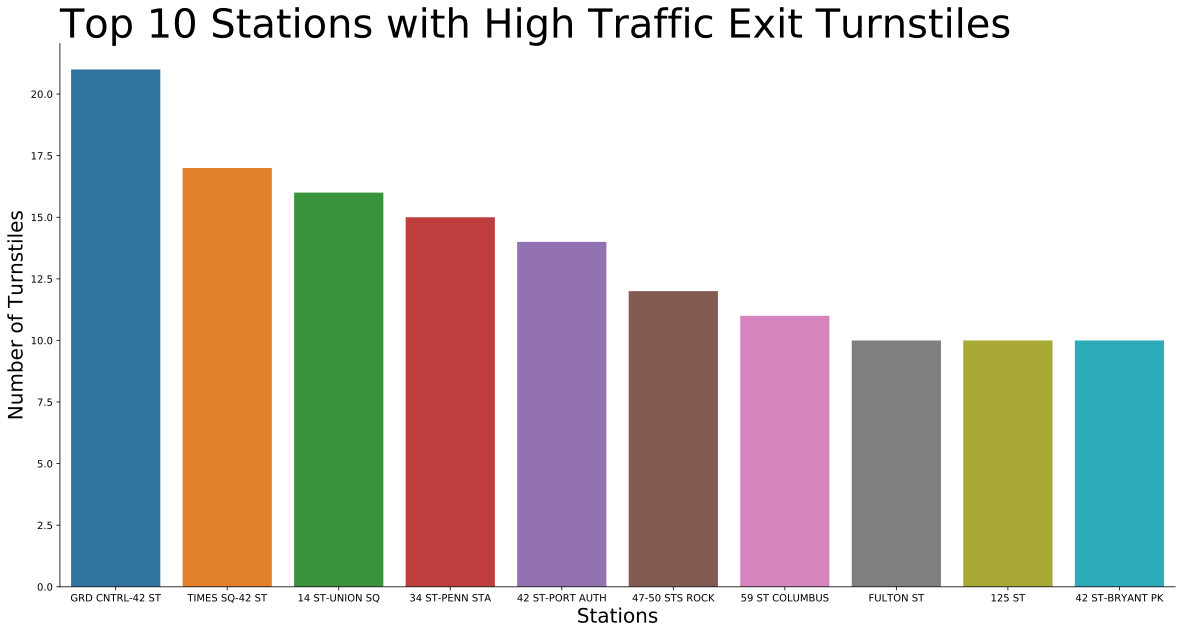

In [247]:
plt.figure(figsize=(20, 10))

ax3=sns.countplot(x="STATION", data=top10_device_exits, order=top10_device_exits.STATION.value_counts().iloc[:10].index);
ax3.set_title('Top 10 Stations with High Traffic Exit Turnstiles', loc='left',fontsize=40)
ax3.set_ylabel('Number of Turnstiles', fontsize=20)
ax3.set_xlabel('Stations', fontsize=20)
fig3 = ax3.get_figure()
sns.despine(fig3)
fig3.savefig('Top 10 Stations Exit by Turnstile #, 3 Months', format='png', dpi=1200);



## 3. Looking at one step further - Day of the Week distribution

We can take a step further and see how we can fine tune our suggestion by looking at exit distributions for the different days of the week.

We first groupby and Device, Date, and Time of the day: This is so that we can calculate average exits per hour at each date in each of the devices.

In [248]:
def max_min(x):
    return x.max() - x.min()

max_min.__name__ = 'diff'

full_data_good_day=full_data_good.groupby(['STATION','C/A','UNIT','SCP','DATE','DAY']).agg({'EXITS':max_min,'DATETIME':max_min})
full_data_good_day["TRAFFIC"]=full_data_good_day['EXITS']/(full_data_good_day['DATETIME'].dt.total_seconds())*3600
full_data_good_day = full_data_good_day.reset_index()

In [249]:
len(full_data_good_day)

370753

We can use the Top 10 Stations we have selected above and look at their exit averages over the 3 months data (by each day):

In [250]:
full_top10_device_list=list(top10_device_exits.STATION.value_counts().iloc[:10].index)
full_data_day_plot=full_data_good_day[full_data_good_day["STATION"].isin(full_top10_device_list)]
full_data_day_plot=full_data_day_plot.groupby(['STATION','DAY']).TRAFFIC.agg("sum")
full_data_day_plot=full_data_day_plot.reset_index()

# full_top10_stations_list=list(top10_station_exits[:10].STATION)
# full_data_day_plot2 = full_data_good_day[full_data_good_day["STATION"].isin(full_top10_stations_list)]
# full_data_day_plot2=full_data_day_plot2.groupby(['STATION','DAY']).TRAFFIC.agg("sum")
# full_data_day_plot2=full_data_day_plot2.reset_index()

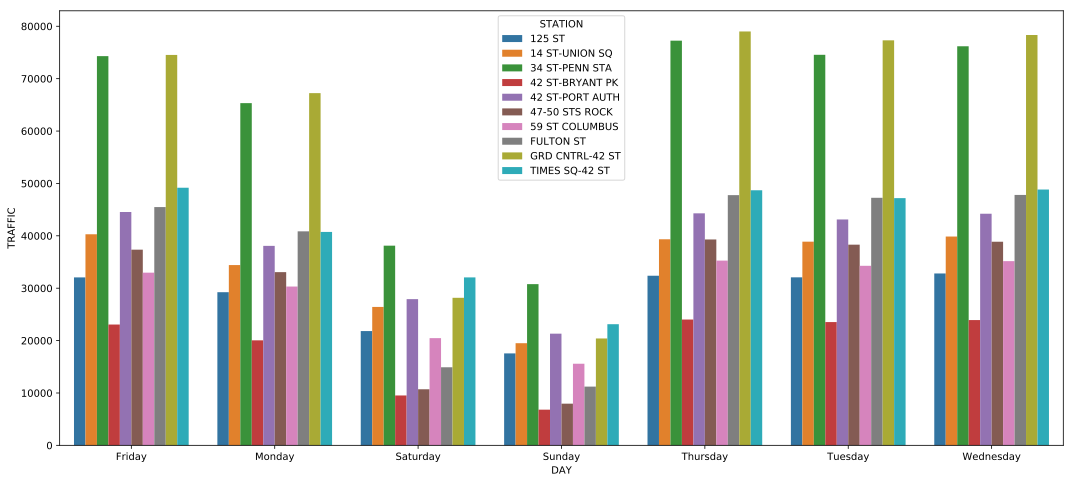

In [253]:
plt.figure(figsize=(18, 8))
sns.barplot(x="DAY",y="TRAFFIC", hue="STATION", data=full_data_day_plot);

This tells us a little bit, but it can be more visually apparent with a heatmap:

In [237]:
data_htmp=pd.pivot_table(full_data_day_plot,index='STATION',columns='DAY',values='TRAFFIC')
data_htmp.columns = pd.CategoricalIndex(data_htmp.columns,categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
data_htmp.sort_index(1,inplace=True)

In [ ]:
plt.figure(figsize=(10, 10))
ax_heat=sns.heatmap(data_htmp,cmap="Greens", vmin=15000,vmax=75000);
ax_heat.set_title('Top 10 Stations\' Exit Traffic, By Day of Week', fontsize=20)
ax_heat.set_xlabel('DAY OF THE WEEK', style='italic', fontweight='bold', labelpad=10)
ax_heat.set_ylabel('STATIONS', style='italic', fontweight='bold', labelpad=10)
fig_heat = ax_heat.get_figure()
fig_heat.savefig('Top 10 Station Exit Traffic By Day of Week', format='png', dpi=1200);


The days of the week heat map shows us to allocate more manpower towards the middle of the weekday - T/W/Th, with Friday also a possibility. Monday should have less staff, with weekends to take minimal staffing.

## 4. Looking at yet another step further - Time of the Day distribution

We wanted take a step further and see how we can fine tune our suggestion by looking at exit distributions for the different days of the week. However we did not get to this step in the constrains of the time given. There are definitely more exploration of the data to be had to improve on our suggestions.